<a href="https://colab.research.google.com/github/visiont3lab/flask-static-website/blob/master/End_to_End_Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to end Machine Learning Project (Regression)

* [Reference book](https://github.com/ageron/handson-ml)
* [Reference notebook](https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb)

## Introduzione

### Dataset Reali: dove trovarli?
---

* [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/)
* [Kaggle Datasets](https://www.kaggle.com/datasets)
* [Amazon's AWS datasets](https://registry.opendata.aws/)

---

* http://dataportals.org/
* http://opendatamonitor.eu/
* http://quandl.com

* [Wikipedia's list of Machine Learning Projects](http://homl.info/9)
* [Quora.com question](http://homl.info/10)
* [Datasets subreddit](https://www.reddit.com/r/datasets)



### Scelta del dataset

Utilizzeremo per questo progetto il California Housing Price dataset con l'aggiunta di variabili categoriche.

> L'obbiettivo è predirre il prezzo medio delle case in uno specifico distretto.

Ad oggi il prezzo medio delle case per distretto è stimato manulamente da degli esperti. Questo approccio è costoso e richiede un enorme quantitativo di tempo.

### Frame the problem

Di che tipo di Machine Problem stiamo parlando? Supervised, Unsupervised, Reinforcement Learning? E' un problema di classificazione, regressione o qualcos'altro?

Stiamo affrontando un problema di Supervised Learning, perchè abbiamo delle label per effettuare il training. Inoltre è un problema di regressione in quanto vogliamo predirre un valore non una classe. Al fine di fare ciò utilizzermo diverse input features.  Il dataset non è enorme e pertanto non è necessario utilizzare online learning approaches.

### Select a performance measure
Normalmente quanto si affronta un problema di regressione si utilizza la Root Mean Square Error (RMSE). Quest'ultima applica un peso molto forte su errore grandi (in predizione) che pertanto risulteranno visibili. Se vi sono molti outliers è preferibile utilizzare il Mean Absolute Error che è meno sensibile agli outliers.

Root Mean Square Error, Euclidean Norm or L2 Norm
* $RMSE(X,h) = \sqrt{ \frac{1}{m}\sum_{i=1}^{m} ( h(x^{(i)}) - y^{(i)}  )^{2}}$

Mean Absolute Error, Manhattan Norm or L1 Norm
* $MAE(X,h) = { \frac{1}{m}\sum_{i=1}^{m} | h(x^{(i)}) - y^{(i)}  |}$

RMSE è più sensibile agli outliers rispetto al MAE.

## Analisi

### Setup

In [17]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(".", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [7]:
#%unload_ext google.colab.data_table
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


### Get the data

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [8]:
housing = load_housing_data()
housing.head()

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

Ogni riga del nostro dataset rappresenta un distretto.

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Da notare che l'input feature total_bedrooms ha $20433/20640$ non nulli. Il che significa che 207 distretti hanno questo input mancante. Inoltre tutte le input features sono numeriche eccetto **ocean_proximity** che è formato da variabili categoriche. Possiamo analizzare le diverse categorie usando la funzione **value_counts()**

In [10]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
housing.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

E' importante sottolineare che i valori nulli vengono ignorati nel metodo describe.

Saving figure attribute_histogram_plots


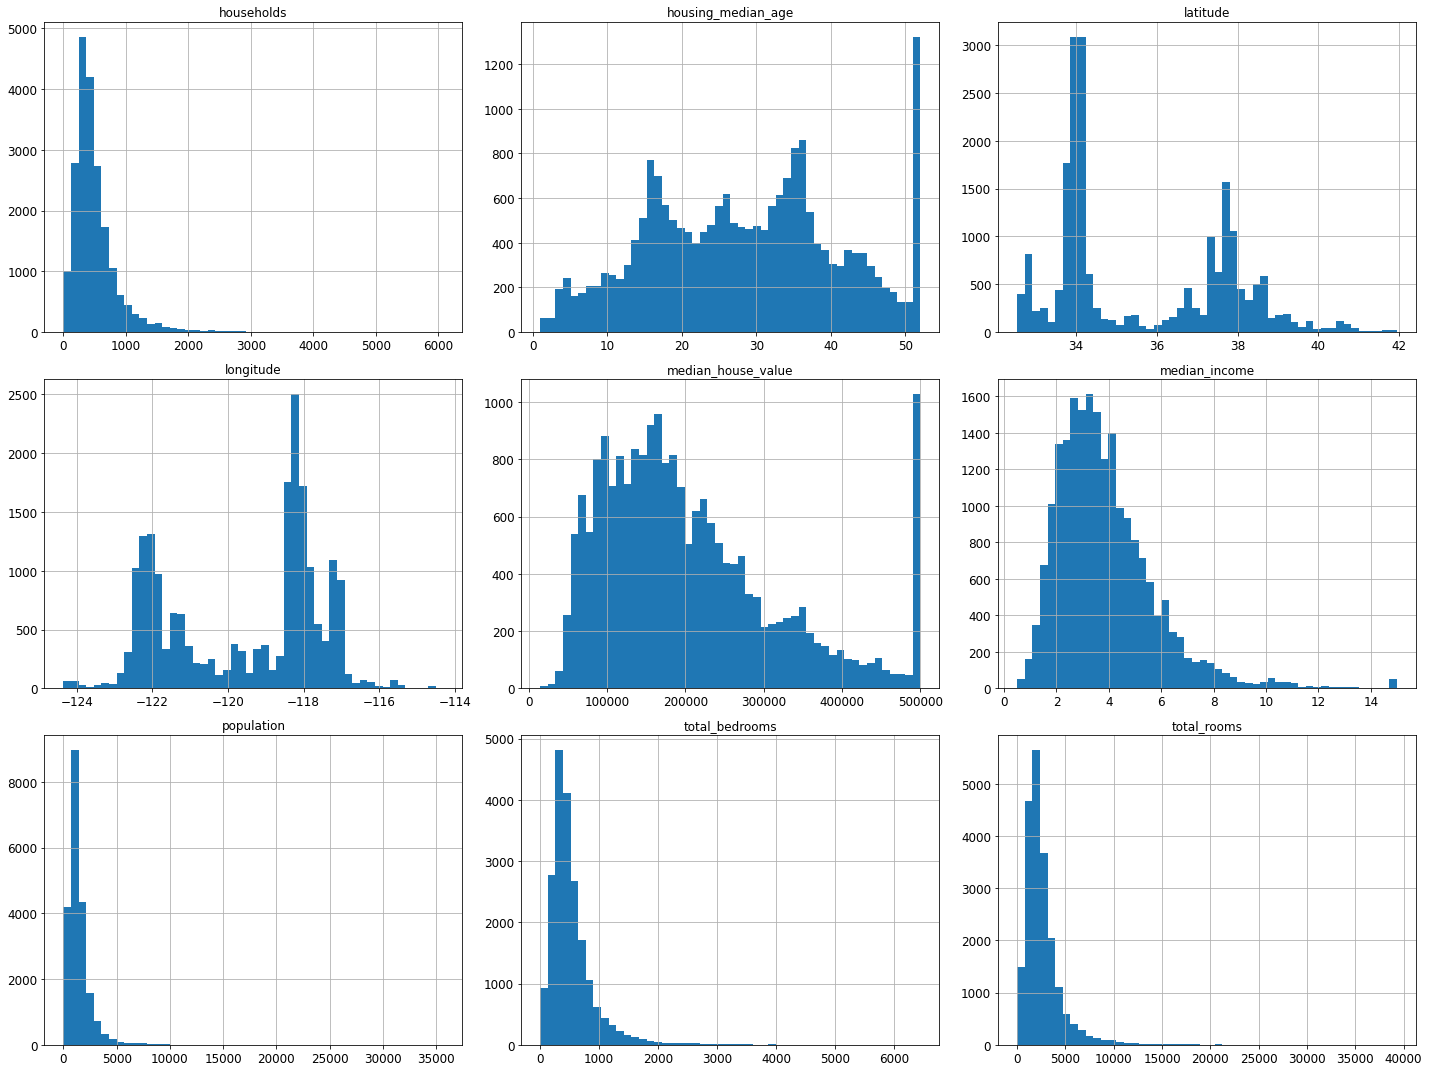

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

E' importante notare che il **median_income** non è espresso in US dollari. Il numero  deve esser moltiplicato per circa 10000 dollari. Pertanto un valore di median_income uguale a 3 va interpretato come $30000.  Inoltre per quanto riguarda sempre il **median_income** è stato introdotto un massimo valore pari a 15001 e un minimo pari a 0.4999. Valori maggiori e minori di essi sono stati esclusi.

E' importante anche sottolineare che è stato introdotto un valore massimo anche per quanto riguarda **housing_median_age** e **median_house**. Per quanto riguarda quest'ultima potremmo avere un problema in quanto è il valore che vogliamo predirre. Inserire un massimo su tale valore significa che l'algoritmo che andremo ad implementare potrebbe imparare che i prezzi non superano mai tale soglia e pertanto potrebbe non predirre tali valori in modo corretto. Una opzione per evitare tale problema sarebbe o di evitare inserire un valore massimo oppure di rimuovere dal dataset tutti i distretti il cui **median_house** è \$500000. Questo perchè non sappiamo se tali valori erano davvero $500000 o erano maggiore di esso.

### Creazione test set

In [23]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Questo tipo di approccio è problematico in quanto  in quanto non ci assicura che il nostro test set sia rappressentativo. 
Nel nostro caso specifico siccome sappiamo che il **median_income** è fondamentale per predirre il **median housing price** dobbiamo assicurarci che vi siano all'interno del test set campioni che rappresentino tutto lo spazio in cui è distribuito il **median_income**.

 Per fare ciò dobbiamo introdurre il concetto di **stratified sampling**. Quest'ultimo consiste nel dividere il dataset in sottogruppi chiamati **strata**, dove ognuno di essi sia rappresentativo per tutto il dataset.


In [24]:
test_set.head()

longitude  latitude  ...  median_house_value  ocean_proximity
20046    -119.01     36.06  ...             47700.0           INLAND
3024     -119.46     35.14  ...             45800.0           INLAND
15663    -122.44     37.80  ...            500001.0         NEAR BAY
20484    -118.72     34.28  ...            218600.0        <1H OCEAN
9814     -121.93     36.62  ...            278000.0       NEAR OCEAN

[5 rows x 10 columns]

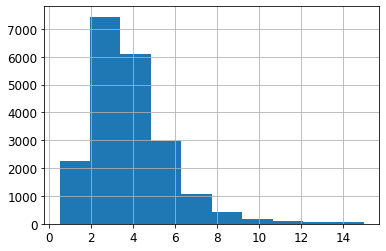

In [33]:
housing["median_income"].hist()

Da tale grafico possiamo concludere che vi sono pochi campioni con valori di median_income superiori a 5. Questa informazione ci servirà per stratificare (quindi creare categorie) di dati associati al median_income.

In [29]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"]< 5, 5.0, inplace=True)

L'idea è quella di creare delle categorie di **median_income**. Per face ciò eseguiamo median_income/1.5 e lo arrotondiamo ad intero. Questo ci permette di creare categorie separate. Dopo di che tutto quello che è maggiare di 5 lo andiamo ad inserire nell'ultima categoria.  Il numero 5 è stato scelto guardando il median_income histogram e osservando che per un valore superiore a 5 il numero di campioni viene ridotto notevolmente.

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

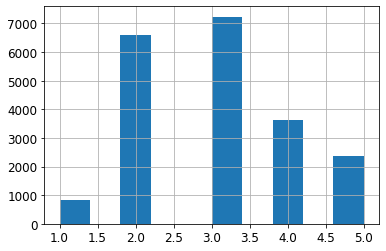

In [32]:
display(housing["income_cat"].value_counts())
housing["income_cat"].hist()

Adesso siamo prointi a creare un test set assicurandoci che vi siano campioni apparteneti a tutte le categorie del median_income

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [35]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [36]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Possiamo osservare che la distribuzione del **median_income** nelle diverse categorie è la medesima sia per quanto riguarda il dataset totale  (overall) che il test set. L'obbiettivo del **stratified_sampling** è quello di creare un test set dove vi siano campiano appartenenti a tutte le categorie del **median_income** con la stessa percentuale del dataset originale.

In [43]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props.round(3)

Overall  Stratified  Random  Rand. %error  Strat. %error
1.0    0.040       0.040   0.040         0.973         -0.243
2.0    0.319       0.319   0.324         1.732         -0.015
3.0    0.351       0.351   0.359         2.266         -0.014
4.0    0.176       0.176   0.167        -5.056          0.027
5.0    0.114       0.115   0.109        -4.318          0.127

Una volta analizzata la differenza tra **Stratified Error** e **Random Error**  e ottenuo il nostro test set possiamo eliminare la colonna **income_cat** precendetemente create per effettuare la stratificazione dal nostro  train e test dataset.

In [44]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Discover and visualize the data to gain insights

In [46]:
# Creiamo un copia del train set
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


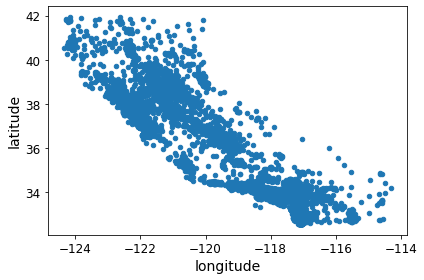

In [47]:
# visualiziamo dati geografici (latitudine, longitudine)
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Da tale grafico è difficile identificare un pattern specifico. Siamo interessati a capire dove vi è maggiore densità. Settiamo pertanto alpha=0.1

Saving figure better_visualization_plot


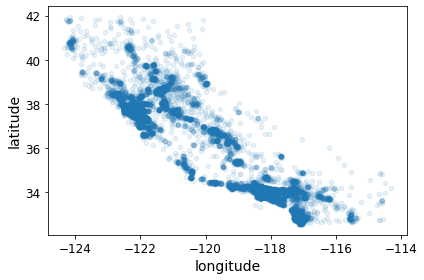

In [49]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Ora siamo in grado di vedere quali sono i distretti dove abbiamo una maggiore quantità di dati (High density area). Essi sono Bay Area, intorno a Los Angeles e San Diego, Central Valley, Sacramento e Fresno.

Andiamo adesso a plottare anche the **housing prices** associato a tale area.

Saving figure housing_prices_scatterplot


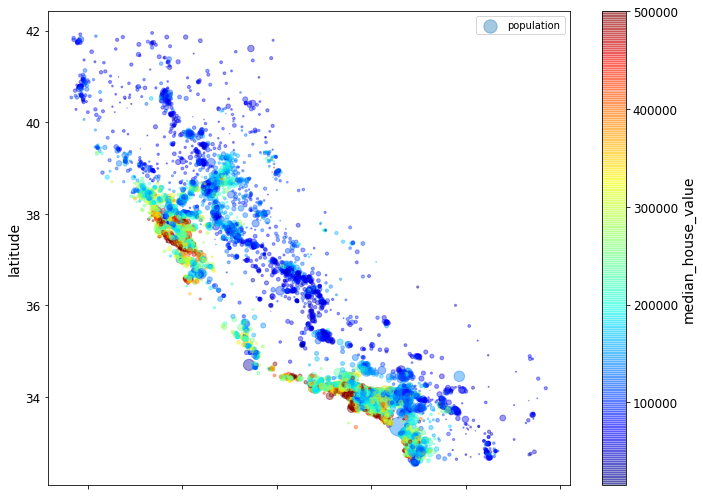

In [51]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
save_fig("housing_prices_scatterplot")

Tale figura ci dice che **the housing prices** è corellato sia alla posizione giografica vicino al mare che alla popolazione. Infatti dove la popolazione è maggiore il prezzo della case aumenta.

In [59]:
!wget https://raw.githubusercontent.com/ageron/handson-ml/master/images/end_to_end_project/california.png

--2020-07-19 16:05:36--  https://raw.githubusercontent.com/ageron/handson-ml/master/images/end_to_end_project/california.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10034 (9.8K) [image/png]
Saving to: ‘california.png’

california.png      100%[===================>]   9.80K  --.-KB/s    in 0s      

2020-07-19 16:05:36 (41.2 MB/s) - ‘california.png’ saved [10034/10034]



Saving figure california_housing_prices_plot


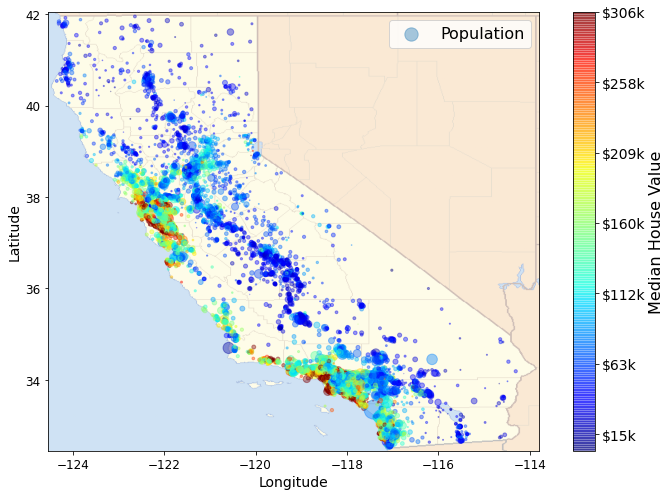

In [60]:
import matplotlib.image as mpimg
california_img=mpimg.imread("california.png")
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### Look for correlation

Siccome il dataset non è enorme possiamo calcolarci la **standard correlation (Pearson's r)** che sussiste tra ogni feature input.

In [61]:
corr_matrix = housing.corr()

In [62]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Il coefficiente di correlazione va da 1 a -1. Quando è vicino ad 1 significa che abbiamo correlazione alta, viceversa bassa. Per esempio possiamo osservare il **median_house_value** tende a salire all'aumentare del **median_income**

> E' importante sottolineare che i corellation coefficients misurano soltato corellazioni di tipo lineare (se un variabile aumenta l'atra o aumenta o diminisce). Non misurano non linearià come il coseno, seno.

Esempio di correlazioni

![SS](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

Saving figure scatter_matrix_plot


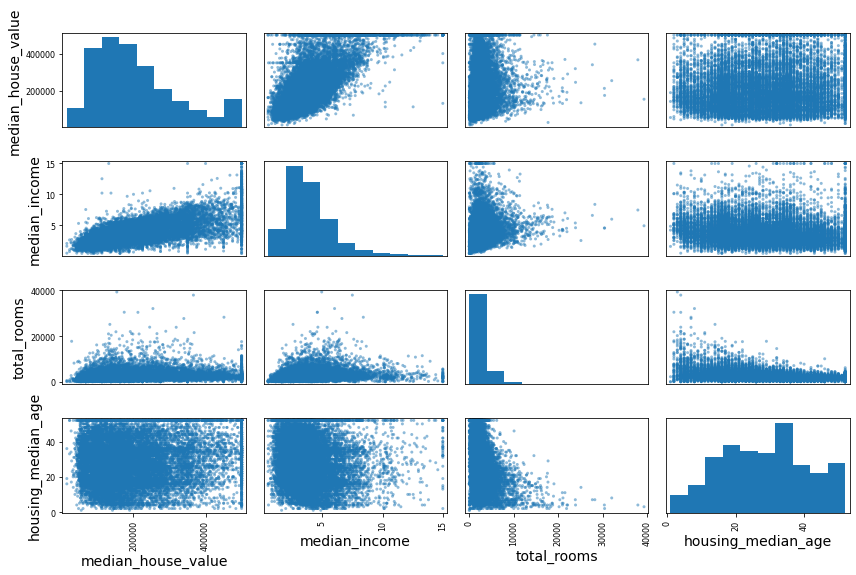

In [63]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Approfondiamo median_income vs median_house_value

Saving figure income_vs_house_value_scatterplot


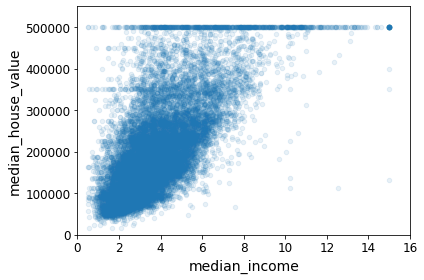

In [65]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

Questo plot ci dice che vi è una forte correlazione tra i due valori. Inoltre possiamo anche osservare il massimale inserito sul median_income che causa una line diritta in prossimità dei valori massimi. Inoltre vi sono diverse linee dirette. Intorno a 280000, 350000, 45000. Sarebbe oppurtuno rimuovere tali distretti (linee) per far si che l'agoritmo non impari a predirre dei massimi inseriti da noi.

### Attribute combinations

Vediamo se per caso vi sono degli inputi che combinati tra di loro hanno una correlazione con il **median_house_value** maggiore di quella che avrebbero da soli.

In [66]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [67]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Sembra che case con più basso rapporto tra letti e camere risultino più costose.

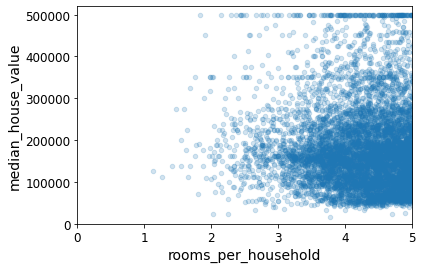

In [68]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

### Recap
Fino ad adesso abbiamo osservato:
    * E' necessario pulire il dataset (data quirks) poichè vi sono dei dati che sono stati arrotandi al massimo valore che causerrebero un errata predizione per il modello.
    * E' necessario che la distribuzione nell'istogramma sia più come una gaussiana. Vogliamo evitare tail-heavy distribution. Si potrebbe utilizzare una scala diversa es. logaritmica.
    * Alcune variabili di input sono poco significative. Ma se combinate con altre aquistano un valore maggiore.

### Prepare the data for machine learnings Algoritms

In [69]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

> Data cleaning. E' fondamentale scegliere cosa fare con i dati nulli. 
* Possiamo cancellare le righe dove **total_bedrooms** è nullo
* Possiamo cancellare l'intera colonna **total_bedrooms** avente valori nulli
*  Possiamo inserire un valore come zero, la meadia, la mediana ect.

In [70]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

longitude  latitude  ...  median_income  ocean_proximity
4629     -118.30     34.07  ...         2.2708        <1H OCEAN
6068     -117.86     34.01  ...         5.1762        <1H OCEAN
17923    -121.97     37.35  ...         4.6328        <1H OCEAN
13656    -117.30     34.05  ...         1.6675           INLAND
19252    -122.79     38.48  ...         3.1662        <1H OCEAN

[5 rows x 9 columns]

In [71]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity]
Index: []

In [72]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

longitude  latitude  ...  median_income  ocean_proximity
4629     -118.30     34.07  ...         2.2708        <1H OCEAN
6068     -117.86     34.01  ...         5.1762        <1H OCEAN
17923    -121.97     37.35  ...         4.6328        <1H OCEAN
13656    -117.30     34.05  ...         1.6675           INLAND
19252    -122.79     38.48  ...         3.1662        <1H OCEAN

[5 rows x 8 columns]

In [73]:
median = housing["total_bedrooms"].median() # la mediana deve essere calcolata sul train set
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

longitude  latitude  ...  median_income  ocean_proximity
4629     -118.30     34.07  ...         2.2708        <1H OCEAN
6068     -117.86     34.01  ...         5.1762        <1H OCEAN
17923    -121.97     37.35  ...         4.6328        <1H OCEAN
13656    -117.30     34.05  ...         1.6675           INLAND
19252    -122.79     38.48  ...         3.1662        <1H OCEAN

[5 rows x 9 columns]

Scikit learn fornisce una classe per interagire con i missing values chimata **Imputer**. E' importante sottolineare che se scegliamo di utilizzare come approccio (il numero 3 , cioè utilizzare la mediana) questa può essere calcolata solo valori numerici e non categorici.

In [79]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

Creiamo una copia dei dati rimuovendo **ocean_proximity**

In [75]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [80]:
imputer.fit(housing_num)

# Compara le mediane
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


E' importante sottilieare che per adesso solamente **total_bedrooms** ha dei valori mancanti. Ma in futuro in fase di test potrebbe essere che vogliao testare il nostro predictor in situazione dove altri valori sono mancanti. In tal caso essi verrano sostituiti con le mediane calcolate dall Imputer.

Una volta allenato l'Imputer possiamo utilizzarlo per transformare i nostro training set.

In [81]:
X = imputer.transform(housing_num)

In [88]:
# Pandas training dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.head()

longitude  latitude  ...  households  median_income
17606    -121.89     37.29  ...       339.0         2.7042
18632    -121.93     37.05  ...       113.0         6.4214
14650    -117.20     32.77  ...       462.0         2.8621
3230     -119.61     36.31  ...       353.0         1.8839
3555     -118.59     34.23  ...      1463.0         3.0347

[5 rows x 8 columns]

In [83]:
housing_tr.loc[sample_incomplete_rows.index.values]

longitude  latitude  ...  households  median_income
4629     -118.30     34.07  ...      1462.0         2.2708
6068     -117.86     34.01  ...       727.0         5.1762
17923    -121.97     37.35  ...       386.0         4.6328
13656    -117.30     34.05  ...       391.0         1.6675
19252    -122.79     38.48  ...      1405.0         3.1662

[5 rows x 8 columns]

In [84]:
# Check  imputer strategy
imputer.strategy

'median'

### Handling Text and Catagorical Attributes

Ricordiamoci che non possiamo calcolarci la mediana di una text variable.

In [89]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

Convertiamo tali valori in numeri

In [90]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [91]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [92]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Un problema con tale rappresentazione è che gli algoritmi di machine learning assumeranno due numeri vicini (0-1) sono più simili (correlati) di due numeri lontani (0-4). Tuttavia questo non è vero. Nel nostro caso 0-4 sono più simi di 0-2.

Al fine di risolvere tale problema è  necesario creare un One-Hot-Encoder. Quest'ultimo converte una rappresentazione

ISLAND = 2

in

| OCEAN' | 'INLAND' | 'ISLAND' | 'NEAR BAY' | 'NEAR OCEAN' |
|--------|----------|----------|------------|--------------|
|   0    |     0    |     1    |      0     |        0     | 


Scikit-learn fornisce una classe OneHotEncoder che permette di convertire  valori interi categorici in one-hot-vectors.



In [100]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False) # vogliamo a dense matrix
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [101]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

E' importante sottolineare che se una vi è una colonna con numerose variabili categoriche, l'approccio one-hot-encoding causa un aumento notevole del numero di features. Questo causerà un degradamento delle performace e velocità in fase di training.

### Custom transformers


Al fine di create un custom transformers è necesario implementare 3 metodi.
* fit()
* transform()
* fit_transform() . In realtà quest'ultimo viene automaticamente generato  aggiunguendo la classe TransformerMixin come basecalss.

Inoltre aggiungendo la classe BaseEstimator otterremo due metodi extra.
* get_params
* set_params
fondamentali per automatic hyperparameter tuning

In [104]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

E' possibile utilizzare anche la classe FunctionTransformer per ottenere il medesimo risultato.

In [105]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [106]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

longitude latitude  ... rooms_per_household population_per_household
17606   -121.89    37.29  ...             4.62537                   2.0944
18632   -121.93    37.05  ...             6.00885                  2.70796
14650    -117.2    32.77  ...             4.22511                  2.02597
3230    -119.61    36.31  ...             5.23229                  4.13598
3555    -118.59    34.23  ...             4.50581                  3.04785

[5 rows x 11 columns]

### Pipeline

> Machine Learing algortithms non performano bene quando gli input numerici hanno scale diverse. Nel nostro caso abbiamo che **total_rooms** va da 6 a 39320 mentre **median_income** va da 0 a 15. Non è necessario eseguire lo scaling sul **target value**.

Vi sono due metodi utilizzati nel feature scaling:
* Min-Max Scaling (Normalization) : i valori vengono shiftati e scalati nel range 0,1.
$ scaled_val = (val -min)/(max-min) dove min e max sono il minimo e il massimo della calonna che si desidera scalare.

* Standardization: prima si sottrae il mean value (quindi standardized values hanno zero mean)  e poi si divide per la devizione standard in modo da avere unit variance. La differenza rispetto a Min-max scaling è che standardization non fissa un range 0-1. E' importante sottolineare che Standardization è molto meno sensibile agli outliers rispetto a min max scaling.

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),  # l'ultimo deve contenere un fit_transform method
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

Vogliamo passare direttamente un dataframe alla nostra pipeline.
Creiamp un DataFrameSelector per scegliere un gruppo di colonne dal dataframe Pandas.

In [113]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [114]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('attribs_adder', CombinedAttributesAdder() ),
        ('std_scaler', StandardScaler()),
    ])
        
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

E' Possibile unire due Pipeline usando **FeatureUnion** class.

In [115]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [119]:
housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared)
print(housing_prepared.shape)

[[-1.15604281  0.77194962  0.74333089 ...  0.          0.
   0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...  0.          0.
   0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...  0.          0.
   1.        ]
 ...
 [ 1.58648943 -0.72478134 -1.56295222 ...  0.          0.
   0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...  0.          0.
   0.        ]
 [-1.43579109  0.99645926  1.85670895 ...  0.          1.
   0.        ]]
(16512, 16)


### Select and train a Model

In [120]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [121]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [122]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Un errore di predizione di 68628 dollari è molto alto in quanto molti distretti hanno valori che vanno da 12000 a 265000. Questo è un esempio di model underfitting che significa che le input features non forniscono abbastanza informazioni per avere buone predizioni.

In [123]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

Proviamo ad allenare un modello come il DecisionTree che è più capace di scovare relazioni non lineari.

In [124]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [125]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Abbiamo un RMSE uguale a zero fantastico. NO! E' quasi sicuro che il modello ha overfittato i dati. Proviamo a valutare il modello usando cross validation.

### Better evaluation using Cross Validation

In [127]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [129]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


Sembra che il DecisionTreeRegressor performi peggio del regressore lineare. E' importante sottolineare che cross-validation permette di misurare anche quanto preciso il modello è (standard deviation).

Applichiamo la cross validation al regressore lineare precendetemete trovato.

In [130]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


Possiamo concludere che il DecisionTreeRegressor overfitta e si comporta peggio del LinearRegressor.

In [131]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [132]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [133]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


Assumiamo che abbiamo individuato un modello promettente come il RandomForestRegressor. Dobbiamo eseguire un fine tuning dei parametri.


### Fine Tune Model

#### Grid Search

In [144]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [136]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [137]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [138]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [ ]:
res = pd.DataFrame(grid_search.cv_results_)
res

#### Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

### Analyze the Best Models and Their Errors

In [142]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [146]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
#cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

### Evaluate your system on Test Set

In [147]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [148]:
final_rmse

47730.22690385927

## Summary

In [ ]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion

# https://scikit-learn.org/stable/modules/compose.html

def get_data():    
    DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
    HOUSING_PATH = os.path.join("datasets", "housing")
    HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

    def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
        os.makedirs(housing_path, exist_ok=True)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
    
    fetch_housing_data()

    def load_housing_data(housing_path=HOUSING_PATH):
        csv_path = os.path.join(housing_path, "housing.csv")
        return pd.read_csv(csv_path)

    housing = load_housing_data()
    return housing

def split_data(housing):
    housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
    housing["income_cat"].where(housing["income_cat"]< 5, 5.0, inplace=True)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

        for set_ in (strat_train_set, strat_test_set):
            set_.drop("income_cat", axis=1, inplace=True)
        return strat_train_set,strat_test_set

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]
        
# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

housing = get_data()
strat_train_set, strat_test_set = split_data(housing) 
housing_train = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_train_labels = strat_train_set["median_house_value"].copy()

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

num_attribs = list(housing_train)
cat_attribs = ["ocean_proximity"]
num_attribs.remove(cat_attribs[0])

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('attribs_adder', CombinedAttributesAdder() ),
        ('std_scaler', StandardScaler()),
    ])
        
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("random_forest", RandomForestRegressor(random_state=42))
    ])

full_pipeline_with_predictor.fit(housing_train, housing_train_labels)

param_grid = {'random_forest__n_estimators': [3,10,30],
              'random_forest__max_features': [2,4,6,8]
            }
grid_search = GridSearchCV(full_pipeline_with_predictor, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_train, housing_labels)
#full_pipeline_with_predictor.predict(some_data)
_

In [ ]:
print(grid_search.best_estimator_)

my_model = grid_search.best_estimator_
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
my_model_loaded = joblib.load("my_model.pkl") # DIFF

In [187]:
final_model = my_model_loaded

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47730.22690385927